In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
!pwd

/home/walml/repos/zoobot/notebooks/multiq


In [9]:
!git pull

Already up-to-date.


In [10]:
import matplotlib.pyplot as plt

(array([1., 3., 2., 2., 6., 0., 0., 0., 3., 2.]),
 array([0.15919279, 0.24163742, 0.32408205, 0.40652668, 0.48897131,
        0.57141594, 0.65386058, 0.73630521, 0.81874984, 0.90119447,
        0.9836391 ]),
 <a list of 10 Patch objects>)

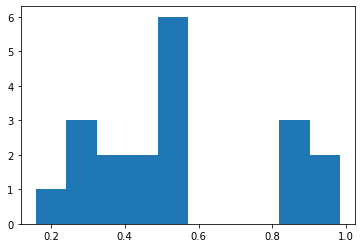

In [11]:
plt.hist(np.random.rand(19))

In [12]:
import os
import logging
import argparse

import numpy as np
import matplotlib
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, default_estimator_params

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [16]:
os.chdir('/home/walml/repos/zoobot')

In [17]:
model_name = 'latest_offline'

In [18]:
# Figures will be saved to here

analysis_dir = 'analysis/multiquestion'
save_dir = f'{analysis_dir}/{model_name}'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
single_model_name = '{}-single'.format(model_name)
single_save_dir = f'{analysis_dir}/{single_model_name}'
if not os.path.exists(single_save_dir):
    os.mkdir(single_save_dir)
assert single_save_dir != save_dir

In [19]:


# NEW_PREDICTIONS = False
NEW_PREDICTIONS = True

### Load the (latest) model under `model_name` folder in `results_dir`

In [20]:
results_dir = 'results'

img_size = 128

tfrecord_loc = f'data/decals/shards/multilabel_{img_size}/eval/s{img_size}_shard_0.tfrecord'

#### Download previously trained model (only if new predictions needed)

#### Download previously-made shards (only if new predictions needed)

### Load original catalog

In [21]:
catalog = pd.read_csv('data/latest_labelled_catalog.csv', dtype={'subject_id': str})

### Predict many rho for the galaxies in tfrecord_loc. Record id_strs to join into catalog later.

**Stop here if you're reloading from saved predictions**

In [22]:
def dummy_acquisition_func(samples):
    return np.random.rand(len(samples))

In [23]:
assert NEW_PREDICTIONS

In [24]:
batch_size = 32
initial_size = 128
final_size = 64
channels = 3

label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'spiral-winding_tight',
    'spiral-winding_medium',
    'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
    'spiral-winding',
    'bar',
    'bulge-size'
]

model = default_estimator_params.get_model(label_cols, questions, final_size)

checkpoint_dir = f'{results_dir}/{model_name}/results/models'
model.load_weights(checkpoint_dir)


eval_config = default_estimator_params.get_eval_config(tfrecord_loc, label_cols, batch_size, initial_size, final_size, channels)
test_dataset = input_utils.get_input(config=eval_config)

{'smooth-or-featured': [0, 1], 'has-spiral-arms': [2, 3], 'spiral-winding': [4, 6], 'bar': [7, 9], 'bulge-size': [10, 14]}
Name: smooth-or-featured, start 0, end 1
Name: has-spiral-arms, start 2, end 3
Name: spiral-winding, start 4, end 6
Name: bar, start 7, end 9
Name: bulge-size, start 10, end 14


In [25]:
n_samples = 3
n_galaxies = 2500


In [26]:
# %timeit predictions = model.predict(test_dataset)
predictions = model.predict(test_dataset)

[[0, 1], [2, 3], [4, 6], [7, 9], [10, 14]]
0 1
2 3
4 6
7 9
10 14


In [27]:
predictions.shape

(3000, 15)

In [28]:
for batch_x, batch_y in test_dataset:
    print(batch_y.numpy())
    break

[[14. 25. 16.  9.  8.  7.  1.  4.  9. 12.  0.  6. 15.  4.  0.]
 [18. 20. 15.  4.  4.  6.  5.  1.  6. 12.  1.  0.  3. 12.  3.]
 [ 4. 24. 20.  3. 13.  6.  1.  0.  4. 19.  2.  0. 12.  9.  0.]
 [ 6. 28. 24.  4.  9. 15.  0.  1. 10. 17.  0.  0.  8. 19.  1.]
 [15. 20.  9. 11.  3.  5.  1.  0.  4. 16.  0.  1.  1. 16.  2.]
 [ 6. 32. 30.  2.  2. 16. 12. 16.  7.  9.  1. 10. 21.  0.  0.]
 [21. 14. 10.  4.  5.  4.  1.  1.  8.  5.  0.  1.  7.  5.  1.]
 [ 3. 34. 32.  2.  3. 20.  9. 24. 10.  0.  0.  4. 21.  9.  0.]
 [24. 12.  5.  6.  1.  1.  3.  2.  2.  7.  5.  0.  2.  3.  1.]
 [ 1. 37. 30.  6.  0.  8. 22.  6. 16. 14.  0.  1. 18. 14.  3.]
 [ 2. 36. 29.  4.  0.  2. 27. 15. 14.  4.  0.  1.  1. 10. 21.]
 [ 2. 36. 33.  2. 12. 16.  5. 19.  6. 10.  0.  7. 24.  4.  0.]
 [ 8. 33. 27.  6.  7. 12.  8.  8. 11. 14.  1.  8. 21.  3.  0.]
 [13. 26. 17.  8.  1. 11.  5.  1.  6. 18.  1.  5. 19.  0.  0.]
 [ 2. 34. 31.  2. 18. 10.  3.  5. 10. 18.  1.  2. 12. 18.  0.]
 [ 1. 37. 35.  1.  8. 23.  4.  0. 18. 18.  0.  2. 12. 2

In [29]:
labels = np.concatenate([batch_y for (_, batch_y) in test_dataset], axis=0)
labels.shape

(3000, 15)

<IPython.core.display.Javascript object>

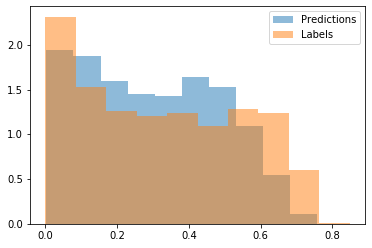

In [38]:
fig, ax = plt.subplots()
ax.hist(predictions[:, 0], alpha=0.5, label='Predictions', density=True)
ax.hist(labels[:, 0] / labels[:, :2].sum(axis=1), alpha=0.5, label='Labels', density=True)
plt.legend()

In [36]:
print(predictions[:, 0].min(), labels[:, 0].min())
print(predictions[:, 0].max(), labels[:, 0].max())

0.0025894665 0.0
0.75806814 129.0


<IPython.core.display.Javascript object>

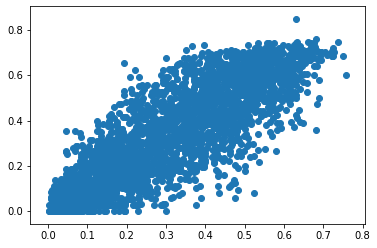

In [39]:
fig, ax = plt.subplots()
ax.scatter(predictions[:, 0], labels[:, 0] / labels[:, :2].sum(axis=1))

<IPython.core.display.Javascript object>

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


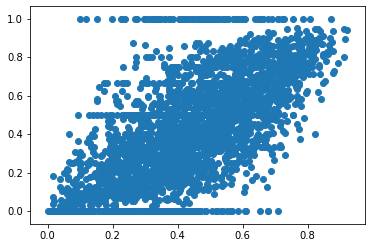

In [40]:
fig, ax = plt.subplots()
ax.scatter(predictions[:, 4], labels[:, 4] / labels[:, 4:7].sum(axis=1))

<IPython.core.display.Javascript object>

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


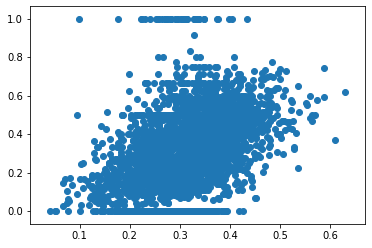

In [41]:
fig, ax = plt.subplots()
ax.scatter(predictions[:, 5], labels[:, 5] / labels[:, 4:7].sum(axis=1))

<IPython.core.display.Javascript object>

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


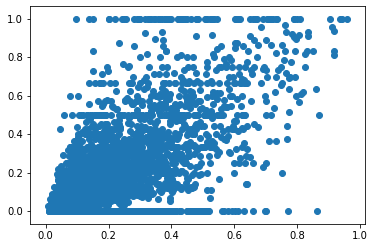

In [42]:
fig, ax = plt.subplots()
ax.scatter(predictions[:, 6], labels[:, 6] / labels[:, 4:7].sum(axis=1))

In [23]:
assert False

AssertionError: 

In [ ]:

images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc, n_galaxies, results_dir, model_name, inital_size=img_size, n_samples=n_samples)
assert samples.shape[1] == n_samples

In [ ]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = dummy_acquisition_func(samples)
# acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
metrics.save_iteration_state(save_dir, subjects, samples, acquisitions)

Repeat for single model

In [ ]:
images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc, n_galaxies, results_dir, model_name, inital_size=256, n_samples=1) # normal model name, for path

In [ ]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = dummy_acquisition_func(samples)
# acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
metrics.save_iteration_state(single_save_dir, subjects, samples, acquisitions)

In [ ]:
# model.show_mutual_info_vs_predictions(save_dir)

### Load the Saved Predictions

In [ ]:
state = metrics.load_iteration_state(save_dir)
model = metrics.Model(state, name=model_name)
assert set(model.id_strs) - set(catalog['subject_id'].values) == set()

In [ ]:
sim_model = simulated_metrics.SimulatedModel(model, catalog)

Repeat for single

In [ ]:
single_state = metrics.load_iteration_state(single_save_dir)
single_model = metrics.Model(single_state, name=model_name)

In [ ]:
single_sim_model = simulated_metrics.SimulatedModel(single_model, catalog)

Are they the same galaxies?

In [ ]:
assert state.id_strs == single_state.id_strs

In [ ]:
single_sim_model.labels 

In [ ]:
sim_model.labels

In [ ]:
fig, ax = plt.subplots()
alpha = 0.6
ax.hist(single_sim_model.labels, bins=30, alpha=alpha)
ax.hist(sim_model.labels, bins=30, alpha=alpha)

They are, but in a different order - remember, catalogs are sorted by acquisition value

In [ ]:
# to check that the right models have been loaded - should be around 40 for smooth, 0-40 for bars
plt.hist(sim_model.total_votes), sim_model.total_votes.mean()

### Visualise Posteriors

Check for systematic offset - in general, model seems slightly skewed towards low k?

In [ ]:
# sns.set_context('paper')
sns.set(font_scale=1.)
sns.set_style('white')
# matplotlib.rcParams.update({'font.size': 50}

# dummy for bins
fig, (ax0, ax1) = plt.subplots(nrows=2)
_, bins_rho, _ = ax0.hist(sim_model.labels/ sim_model.total_votes, bins=25, alpha=alpha, label='Actual')
_, bins_k, _ = ax1.hist(sim_model.labels, bins=25, alpha=alpha, label='Actual')

fig, (ax0, ax1) = plt.subplots(nrows=2)

_, bins, _ = ax0.hist(sim_model.mean_rho_prediction, bins=bins_rho, alpha=alpha, label='Model')
ax0.hist(sim_model.labels/ sim_model.total_votes, bins=bins_rho, alpha=alpha, label='Actual')
ax0.set_xlabel(r'Vote Fraction $\rho$')
ax0.set_ylabel('Galaxies')
ax0.legend()
ax0.set_xlim([0., 1.])

_, bins, _ = ax1.hist(sim_model.expected_k_prediction, bins=bins_k, alpha=alpha, label='Model')
ax1.hist(sim_model.labels, bins=bins_k, alpha=alpha, label='Actual')
ax1.set_xlabel(r'Positive Responses $k$')
ax1.set_ylabel('Galaxies')
ax1.legend()
ax1.set_xlim([0, 40])

fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.png'))
# fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.pdf'))

In [ ]:
def custom_samples(samples, labels, total_votes):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, total_votes, fig, axes, alpha=0.06)
    for ax in axes:
        ax.set_xlim([0, 50])
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig

In [ ]:
def custom_samples_with_galaxies(sim_model, selected_slice):
    
    samples = np.array(sim_model.model.samples)[selected_slice]
    labels = np.array(sim_model.labels)[selected_slice]
    total_votes = sim_model.total_votes[selected_slice]
    catalog = sim_model.catalog[selected_slice]
    
    
    sns.set_context('paper', font_scale=1.5)
    
    im_width = 2
    single_width = 3
    multiple_width = 3
    height = im_width
    
    fig = plt.figure(figsize=(0.8 * len(labels) * height / 1.5, 0.8 * (im_width + single_width + multiple_width) * 1.75))
    gs = gridspec.GridSpec(len(labels) * height, im_width + single_width + multiple_width)  # y, x format
    image_axes = []
    single_axes = []
    multiple_axes = []
    for galaxy_n in range(len(labels)):
        x_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[x_slice, :im_width]))
        single_axes.append(plt.subplot(gs[x_slice, im_width:im_width+single_width]))
        multiple_axes.append(plt.subplot(gs[x_slice, im_width+single_width:]))
    

#     fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples[:, :1], labels, total_votes, fig, single_axes, alpha=0.06)
    for ax in single_axes:
        ax.set_xlim([0, 50])

    make_predictions.plot_samples(samples, labels, total_votes, fig, multiple_axes, alpha=0.06)
    for ax in multiple_axes:
        ax.set_xlim([0, 50])
        
        
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(catalog.iloc[ax_n]['png_loc'], ax)
        
    
    for n in range(len(labels)):
        multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
        multiple_axes[n].yaxis.set_visible(True)
        single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
        single_axes[n].yaxis.set_visible(True)
        single_axes[n].yaxis.set_major_locator(plt.NullLocator())
        multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
        if n < len(labels) - 1:
            single_axes[n].xaxis.set_major_locator(plt.NullLocator())
            multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
    if QUESTION == 'bars':
        question = 'Bar'
    else:
        question = 'Smooth'
    single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    fig.tight_layout()

    single_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    
    multiple_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )

    
    fig.tight_layout()
    return fig

In [ ]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
    if QUESTION == 'bars':
        crop = 120
    else:
        crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [ ]:
# fig, axes = plt.subplots(1, 10, figsize=(20, 12))
# for ax_n, ax in enumerate(axes):
#     plot_galaxy(sim_model.catalog.iloc[ax_n]['png_loc'], ax)

In [ ]:
# 1 2

In [ ]:
selected = slice(80, 73, -1)  # smooth

# selected = slice(0, 7)

if QUESTION == 'bars':
    selected = slice(0, 7)

In [ ]:
# np.array(sim_model.model.samples)[selected, :]
# np.array(sim_model.labels)[selected]
# sim_model.catalog['smooth-or-featured_total-votes'][selected]

In [ ]:
fig = custom_samples_with_galaxies(sim_model, selected)
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.pdf'.format(len(np.array(sim_model.labels)[selected]))))

In [ ]:
# be sure to switch label in custom_samples before running this
# fig = custom_samples(np.array(single_sim_model.model.samples)[selected, :1], np.array(single_sim_model.labels)[selected], total_votes=single_sim_model.total_votes)
# fig.savefig(os.path.join(save_dir, 'single_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'single_model_{}.eps'.format(len(np.array(sim_model.labels)[selected]))))

In [ ]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots()
ungrouped_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    sim_model.labels, 
    sim_model.bin_probs)
coverage_df = ungrouped_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()

ungrouped_single_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    single_sim_model.labels, 
    single_sim_model.bin_probs)
single_coverage_df = ungrouped_single_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()


plt.plot(coverage_df['max_state_error'], coverage_df['prediction'], label='MC Model Expects')
plt.plot(single_coverage_df['max_state_error'], single_coverage_df['prediction'], label='Single Model Expects')
plt.plot(single_coverage_df['max_state_error'], coverage_df['observed'], 'k--', label='Actual')

ax.set_xlabel('Max Allowed Vote Error')
ax.set_ylabel('Galaxies Within Max Error')
ax.legend()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # must expect 'x' kw arg

ax.set_xlim([0, 15])
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.png'))
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.pdf'))

In [ ]:
ungrouped_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)
ungrouped_single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)

In [ ]:
coverage_df['error'] = coverage_df['prediction'] - coverage_df['observed']
coverage_df['relative_error'] = coverage_df['error'] / coverage_df['observed']
coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_coverage_df.csv'), index=False)
coverage_df.head(20)

In [ ]:
single_coverage_df['error'] = single_coverage_df['prediction'] - single_coverage_df['observed']
single_coverage_df['relative_error'] = single_coverage_df['error'] / single_coverage_df['observed']
single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_single_coverage_df.csv'), index=False)
single_coverage_df.head(20)

TODO - I might consider adding an MSE model as a comparison, to hopefully beat. I think this might be quite similar though. Ideally I can compare this with previous work somehow.

In [ ]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
ax.hist(sim_model.abs_rho_error, bins=25)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
ax.set_ylabel('Galaxies')
ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

In [ ]:
sim_model.abs_rho_error.mean(), single_sim_model.abs_rho_error.mean()

In [ ]:
np.sqrt(sim_model.mean_abs_rho_error), np.sqrt(single_sim_model.mean_abs_rho_error)  

In [ ]:
np.sqrt(sim_model.mean_square_rho_error), np.sqrt(single_sim_model.mean_square_rho_error) # this is the rmse

In [ ]:
# alpha = 0.3
# n_bins = 25

# # dummy for bins
# fig, ax = plt.subplots()
# _, bins, _  = ax.hist(sim_model.labels / sim_model.total_votes, bins=n_bins, alpha=alpha, label=r'Observed $\rho$')
# ax.hist(sim_model.mean_rho_prediction, bins=n_bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')

# fig, ax = plt.subplots()
# sns.set(font_scale=1.)
# sns.set_style('white')

# ax.hist(sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')
# ax.hist(sim_model.labels / sim_model.total_votes, bins=bins, alpha=alpha, label=r'Observed $\rho$')
# ax.legend()
# ax.set_xlim([0., 1.])
# ax.set_ylabel('Galaxies')
# ax.set_xlabel(r'Typical vote fraction $\rho$')
# fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'typical_vote_fraction_distribution.png'))

# This is a repeat of the above histograms

In [ ]:
np.sum(sim_model.mean_rho_prediction > 0.5), np.sum(single_sim_model.mean_rho_prediction > 0.5), np.sum((sim_model.labels / sim_model.total_votes) > 0.5)

In [ ]:
(sim_model.labels / sim_model.total_votes).min(), (sim_model.labels / sim_model.total_votes).max()

In [ ]:
sim_model.mean_rho_prediction.min(), sim_model.mean_rho_prediction.max()

In [ ]:
single_sim_model.mean_rho_prediction.min(), single_sim_model.mean_rho_prediction.max()

In [ ]:
sim_model.total_votes

## Save DataFrame of predictions + catalog (GZ2) for use elsewhere

In [ ]:
import json

In [ ]:
response_df = pd.DataFrame(data={
    'total_votes': sim_model.total_votes, 
    'k': sim_model.labels, 
    'vote_fraction': (sim_model.labels / sim_model.total_votes), 
    'rho_prediction': sim_model.mean_rho_prediction
#     'png_loc': sim_model.catalog.png_loc
})
safe_catalog_cols = list(set(sim_model.catalog.columns.values) - set(['total_votes', 'ra_subject', 'dec_subject']))
df = pd.concat([response_df, sim_model.catalog[safe_catalog_cols]], axis=1)
df['smooth'] = df['vote_fraction'] > 0.5
df['confidence_proxy'] = np.abs(0.5 - df['rho_prediction'])
df['rho_predictions'] = 0
for n in range(len(df)):
    df['rho_predictions'][n] = json.dumps(list(sim_model.model.samples[n, :]))
    df = df.sort_values('confidence_proxy', ascending=False)

In [ ]:
df['rho_predictions']

In [ ]:
df.head()

In [ ]:
df.to_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))

### Replicate (ish) Sanchez 2017 ROC Curves

In [ ]:
confusion_matrix((sim_model.labels / sim_model.total_votes) > 0.5, sim_model.mean_rho_prediction > 0.5)

In [ ]:
 1 - ((66 + 99) / (490 + 1845 + 66 + 99))

In [ ]:
 1 - ((189 + 81) / (1858 + 189 + 81 + 372))

In [ ]:
fig, ax = plt.subplots()
sns.set(font_scale=1.2)
sns.set_style('white')

fpr, tpr, _ = roc_curve(df['smooth'], df['rho_prediction'])
ax.plot(fpr, tpr, label='All')
df_low_entropy = df[df['confidence_proxy'] > 0.3]
fpr, tpr, _ = roc_curve(df_low_entropy['smooth'], df_low_entropy['rho_prediction'])
ax.plot(fpr, tpr, label=r'"High Confidence" i.e. $\hat{\rho} < 0.2$ or $\hat{\rho} > 0.8$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'))
fig.savefig(os.path.join(save_dir, 'roc_curve.pdf'))

In [ ]:
len(df), len(df_low_entropy)

### Replicate(ish) Khan 2018 Confusion Matrices

> After selecting the OBJIDs from Table 2 based on the probability thresholds of 0.985 and 0.926 for spirals and ellipticals respectively,

In [ ]:
df.sample(1)

In [ ]:
cdf_array = binom.cdf((df['total_votes'] / 2.).astype(int), df['total_votes'], df['rho_prediction'])

In [ ]:
(df['total_votes'] / 2.).astype(int).sample(10)

In [ ]:
df['total_votes'].sample(10)

In [ ]:
df['rho_prediction'].sample(10)

In [ ]:
plt.hist(cdf_array, bins=30)

In [ ]:
binom.cdf(20, 40, 0.88)

In [ ]:
sum(1 - cdf_array > 0.985)

In [ ]:
sum(cdf_array > 0.926)

In [ ]:
high_prob_df = df[(cdf_array < (1 - 0.985)) | (cdf_array > 0.926)]

In [ ]:
len(high_prob_df)

In [ ]:
if QUESTION == 'smooth':
    spiral_pc_to_keep = 516 / 6677
    n_spirals = int(len(df) * spiral_pc_to_keep)
    elliptical_pc_to_keep = 550 / 5904
    n_ellipticals = int(len(df) * elliptical_pc_to_keep)
    print(spiral_pc_to_keep, n_spirals, elliptical_pc_to_keep, n_ellipticals)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:n_spirals],
        df.sort_values('rho_prediction', ascending=False)[:n_ellipticals]
    ])
if QUESTION == 'bars':
    n_to_keep = int(len(df) * 0.08)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:int(n_to_keep/2)],
        df.sort_values('rho_prediction', ascending=False)[:int(n_to_keep/2)]
    ])



In [ ]:
high_prob_df.sample(20)

In [ ]:
confusion_matrix(high_prob_df['vote_fraction'] >= 0.5, high_prob_df['rho_prediction'] >= 0.5)

In [ ]:
error = high_prob_df[~(high_prob_df['vote_fraction'] > 0.5) & (high_prob_df['rho_prediction'] > 0.5)]

In [ ]:
error

In [ ]:
error['vote_fraction'] > 0.5, error['rho_prediction'] > 0.5

In [ ]:
img = Image.open(error.iloc[0]['png_loc'])
plt.imshow(img)
fontdict = {'size': 16, 'color': 'white'}
plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.80', fontdict=fontdict)
plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.50', fontdict=fontdict)
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.png'))
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.eps'))

In [ ]:
# img = Image.open(error.iloc[1]['png_loc'])
# plt.imshow(img)
# fontdict = {'size': 16, 'color': 'white'}
# plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.13', fontdict=fontdict)
# plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.54', fontdict=fontdict)
# plt.axis('off')
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.png'))
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.eps'))

In [ ]:
confusion_matrix(df['vote_fraction'][:int(len(df) / 2)] > 0.5, df['rho_prediction'][:int(len(df) / 2)] > 0.5)

In [ ]:
if QUESTION == 'smooth':
    labels = ['Smooth', 'Featured']
    
#     cm = np.array([[ 232,    2], [   0, 191]])
#     name = 'confusion_matrix_high_confidence'
    
    cm = np.array([[ 490,   66],
       [  99, 1845]])
    name = 'confusion_matrix'
    
if QUESTION == 'bars':
    labels = ['No Bar', 'Bar']
    cm = np.array([[100,    0], [   0,   100]])
    name = 'confusion_matrix_high_confidence'
    
#     cm = np.array([[1858,    81], [   189,   372]])
#     name = 'confusion_matrix'

sns.set(font_scale=3.)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False, square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, '{}.png'.format(name)))
fig.savefig(os.path.join(save_dir, '{}.pdf'.format(name)))

In [ ]:
1 - (8 / (1159 + 83 + 8))

In [ ]:
# sim_model.export_performance_metrics(save_dir)

In [ ]:
# Draw a galaxy, infer a range of p, redraw, and measure accuracy - work in progress

### Plot other standard acquisition visualisations

In [ ]:
new_acquisition_viz = False
if new_acquisition_viz:
    image_locs = sim_model.catalog['png_loc']
    images = np.stack([np.array(Image.open(loc)) for loc in image_locs])
    assert images.shape == (2500, 424, 424, 3)
    acquisition_utils.save_acquisition_examples(images, sim_model.mutual_info, 'mutual_info', save_dir)

In [ ]:
# fig, row = plt.subplots(ncols=3, figsize=(12, 4))

In [ ]:
# row = sim_model.acquisition_vs_volunteer_votes(row)

### Visualise Selection of Catalog Features w.r.t. Acquisition Function

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = gridspec.GridSpec(6, 5, figure=fig)

#### Smooth Votes

In [ ]:
ax0 = plt.subplot(gs[:4, :])
sns.scatterplot(
    np.array(sim_model.catalog['smooth-or-featured_smooth_fraction'] * 40).astype(int),
    sim_model.model.acquisitions, hue=np.array(sim_model.model.acquisitions) > np.array(sim_model.model.acquisitions[103]),
    ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Smooth Votes')
ax0.legend([r'Top 10% $\mathcal{I}$', r'Bottom 90% $\mathcal{I}$'])

In [ ]:
ax1 = plt.subplot(gs[4:, :])
ax1.hist(np.array(sim_model.labels * 40).astype(int), density=True, alpha=0.4)
ax1.hist(np.array(sim_model.labels * 40).astype(int)[:200], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')

In [ ]:
plt.savefig(os.path.join(save_dir, 'temp.png'))

#### Redshift

In [ ]:
fig, ax = plt.subplots()
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde')
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde', ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(sim_model.catalog['redshift'], sim_model.model.acquisitions, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Redshift')

In [ ]:
ax1 = plt.subplot(gs[4:, :])

ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
# ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')
# TODO sort by mutual information

### Below here is only relevant for DECALS, with extra questions. TODO update with GZ2 merger options?

In [ ]:
assert False

In [ ]:
merger_strs

In [ ]:
merger_label = 'merging_major-disturbance'

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog[merger_label], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel(merger_label)

In [ ]:
_ = plt.hist(sim_model.catalog[merger_label], bins=40)

In [ ]:
featured_no_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] == 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]
featured_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] > 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]

In [ ]:
featured_no_merger.mean()

In [ ]:
featured_merger.mean()

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(featured_no_merger, alpha=0.3, density=True)

In [ ]:
ax.hist(featured_merger, alpha=0.3, density=True)

In [ ]:
fig

In [ ]:
ax = sns.scatterplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info, 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103])
ax.set_xlim([0, 14.5])

In [ ]:
sns.regplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig

In [ ]:
has-spiral-arms_yes
spiral-winding_prediction-encoded

In [ ]:
sns.scatterplot(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    sim_model.model.mutual_info[sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[100])

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
for merger_label in merger_strs:
    print('\n' + merger_label)
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] > 1].mean())
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] == 1].mean())

In [ ]:
data = [
    {'Volunteer Response': 'Merging', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_both-v1'] > 1].mean()},
    {'Volunteer Response': 'Major Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_major-disturbance'] > 1].mean()},
    {'Volunteer Response': 'Minor Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_minor-disturbance'] > 1].mean()},
    {'Volunteer Response': 'No Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_none'] > 20].mean()}
    ]

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df, y='Volunteer Response', x='Mean Mutual Information', ax=ax)
ax.set_xlim([0.2, 0.36])
fig.tight_layout()

In [ ]:
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) > 0].mean())
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) == 0].mean())

In [ ]:
plt.hist(sim_model.catalog['merging_tidal-debris-v1'], bins=40)